<a href="https://colab.research.google.com/github/MikeMNelhams/SkyBroadbandProject/blob/main/SkyBroadband_UnsupervisedAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

[https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization)

[https://en.wikipedia.org/wiki/Kernel_density_estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)

[https://stats.stackexchange.com/questions/13781/clustering-1d-data](https://stats.stackexchange.com/questions/13781/clustering-1d-data) 

[https://pbpython.com/natural-breaks.html](https://pbpython.com/natural-breaks.html)


In [126]:
!pip install jenkspy

In [186]:
# Package Import Statements
%matplotlib inline

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import jenkspy # For using the Fisher-Jenks algorithm
from google.colab import files # For saving files

In [128]:
# Data Import Statements Quarterly
complaints_data_url = "https://raw.githubusercontent.com/MikeMNelhams/SkyBroadbandProject/main/ComplaintsData/Complaints_Broadband.csv"
df_cd = pd.read_csv(complaints_data_url) # df_cd is an abreviation for dataframe complaints_data

# Data Import Statements Monthly 
complaints_data_all_url = "https://raw.githubusercontent.com/MikeMNelhams/SkyBroadbandProject/main/ComplaintsData/complaints_data_all.csv"
df_cda = pd.read_csv(complaints_data_all_url) # df_cda is an abreviation for dataframe complaints_data_all

df_cda

,Company,10 2010,11 2010,12 2010,01 2011,02 2011,03 2011,04 2011,05 2011,06 2011,07 2011,08 2011,09 2011,10 2011,11 2011,12 2011,01 2012,02 2012,03 2012,04 2012,05 2012,06 2012,07 2012,08 2012,09 2012,10 2012,11 2012,12 2012,01 2013,02 2013,03 2013,04 2013,05 2013,06 2013,07 2013,01 2013.1,01 2013.2,01 2013.3,01 2013.4,01 2013.5,...,09 2016,10 2016,11 2016,12 2016,01 2017,02 2017,03 2017,04 2017,05 2017,06 2017,07 2017,08 2017,09 2017,10 2017,11 2017,12 2017,01 2018,02 2018,03 2018,04 2018,05 2018,06 2018,07 2018,08 2018,09 2018,10 2018,11 2018,12 2018,01 2019,02 2019,03 2019,04 2019,05 2019,06 2019,07 2019,08 2019,09 2019,10 2019,11 2019,12 2019
0,BT,10.0,12.0,12.0,13.0,12.0,16.0,12.0,16.0,15.0,13.0,19.0,17.0,14.0,14.0,11.0,12.0,13.0,12.0,11.0,10.0,10.0,12.0,11.0,11.0,12.0,10.0,8.0,12.0,11.0,10.0,10.0,10.0,9.0,12.0,15.0,13.0,12.0,12.0,8.0,...,13.0,12.0,11.0,10.0,10.0,11.0,13.0,11.0,10.0,8.0,9.0,8.0,8.0,9.0,10.0,8.0,10.0,7.0,6.0,6.0,5.0,5.0,7,8,6,7,6,5,6,4,4,4,4,3,5,5,4,4,4,3
1,EE,9.0,9.0,6.0,9.0,12.0,17.0,10.0,13.0,13.0,15.0,14.0,14.0,17.0,16.0,12.0,11.0,12.0,14.0,11.0,9.0,9.0,11.0,14.0,24.0,28.0,28.0,16.0,23.0,17.0,16.0,11.0,11.0,11.0,17.0,14.0,15.0,12.0,10.0,7.0,...,9.0,8.0,12.0,6.0,8.0,8.0,8.0,6.0,4.0,5.0,4.0,4.0,2.0,3.0,5.0,5.0,4.0,4.0,5.0,3.0,2.0,2.0,2,2,3,3,3,3,1,2,2,2,1,2,2,1,1,1,2,2
2,Plusnet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,10.0,12.0,9.0,8.0,9.0,8.0,7.0,7.0,6.0,10.0,10.0,7.0,10.0,8.0,8.0,8.0,6.0,6.0,5.0,5.0,6.0,5,6,10,15,16,12,9,12,11,9,10,7,9,8,6,8,7,6
3,Post Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,2,4,3,2,3,2,3,3,1,2,2,3,5,5,4,4
4,Sky,5.0,7.0,8.0,7.0,7.0,8.0,6.0,7.0,7.0,5.0,6.0,7.0,6.0,6.0,5.0,6.0,5.0,5.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,2.0,3.0,3.0,3.0,2.0,...,3.0,3.0,2.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2,2,2,2,2,1,1,2,3,2,2,2,2,2,1,1,2,2
5,TalkTalk Group,25.0,36.0,25.0,30.0,29.0,31.0,22.0,24.0,20.0,14.0,23.0,24.0,25.0,23.0,17.0,20.0,19.0,21.0,17.0,16.0,11.0,13.0,14.0,10.0,13.0,12.0,9.0,12.0,10.0,10.0,11.0,11.0,7.0,8.0,9.0,10.0,9.0,8.0,7.0,...,7.0,8.0,11.0,9.0,10.0,8.0,11.0,8.0,7.0,9.0,9.0,10.0,11.0,12.0,12.0,7.0,11.0,7.0,11.0,8.0,9.0,7.0,8,8,7,6,8,6,8,7,8,9,7,7,7,9,5,6,7,6
6,Virgin Media,3.0,4.0,4.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,7.0,6.0,7.0,5.0,6.0,5.0,6.0,4.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,2.0,1.0,3.0,3.0,3.0,3.0,2.0,2.0,...,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,3.0,5.0,4.0,4.0,4.0,3,5,5,5,6,3,4,3,3,4,5,7,7,7,6,5,5,4
7,Vodafone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,10,10,7,8,10,9,10,12,12,9,9,8,9,9,10,9,9
8,Industry Average,10.0,14.0,11.0,13.0,12.0,14.0,11.0,12.0,12.0,10.0,13.0,13.0,12.0,12.0,9.0,10.0,10.0,11.0,9.0,8.0,7.0,8.0,8.0,7.0,9.0,8.0,6.0,8.0,7.0,7.0,7.0,6.0,5.0,7.0,8.0,8.0,7.0,6.0,5.0,...,8.0,7.0,7.0,6.0,6.0,6.0,8.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,7.0,5.0,6.0,5.0,5.0,5.0,4.0,4.0,5,6,5,5,6,4,5,4,4,5,4,4,5,5,4,4,4,4


In [129]:
# Data Formatting and remove all company names
df_cd_sky = df_cd.copy() 
df_cd_valid = df_cd.copy()
df_cd_ia = df_cd.copy()

df_cda_sky = df_cda.copy() 
df_cda_valid = df_cda.copy()
df_cda_ia = df_cda.copy()

### Only Sky ###
filter = (df_cd_sky["Company"]=="Sky")
df_cd_sky.where(filter, inplace = True) 
df_cd_sky.dropna(inplace = True)

filter = (df_cda_sky["Company"]=="Sky")
df_cda_sky.where(filter, inplace = True) 
df_cda_sky.dropna(inplace = True)

### Removing Plusnet, Post Office, Vodafone and Industry Average
filter = (df_cd_valid["Company"]!="Industry Average ")
df_cd_valid.where(filter, inplace = True) 
df_cd_valid.dropna(inplace = True)

filter = (df_cda_valid["Company"]!="Industry Average ")
df_cda_valid.where(filter, inplace = True) 
df_cda_valid.dropna(inplace = True)

### Only Industry Average ###
filter = (df_cd_ia["Company"]=="Industry Average ")
df_cd_ia.where(filter, inplace = True) 
df_cd_ia.dropna(inplace = True)

filter = (df_cda_ia["Company"]=="Industry Average ")
df_cda_ia.where(filter, inplace = True) 
df_cda_ia.dropna(inplace = True)

### Create NP ARRAY copies of the dataframes and shift all the names into the column name/indexes ###
# Create the numpy copies
df_cd_valid.drop(["Company"], axis=1, inplace=True) # Drop the names into columns
df_cd_ia.drop(["Company"], axis=1, inplace=True) # Drop the names into columns
df_cd_sky.drop(["Company"], axis=1, inplace=True) # Drop the names into columns 
cd_ia = df_cd_ia.to_numpy()
cd_sky = df_cd_sky.to_numpy()
cd_valid = df_cd_valid.to_numpy()

df_cda_valid.drop(["Company"], axis=1, inplace=True) # Drop the names into columns
df_cda_ia.drop(["Company"], axis=1, inplace=True) # Drop the names into columns
df_cda_sky.drop(["Company"], axis=1, inplace=True) # Drop the names into columns 
cda_ia = df_cda_ia.to_numpy()
cda_sky = df_cda_sky.to_numpy()
cda_valid = df_cda_valid.to_numpy()

# Completed Functions
def sort_quarterly_indices(cd_df):
  # A list input of the indices
  # INDEX FORMAT: 'QA 20BB'
  indices = list(cd_df.index.values)
  columns = list(cd_df.columns)
  col_values = list(cd_df.iloc[:,0])
  col_values2 = list(cd_df.iloc[:,1])
  a, b = [], []
  
  for index in indices: 
      a.append(index[1]) #
      b.append(index[5:7])
  indices = np.array([indices, a, b, col_values, col_values2]).T
  indices = indices[indices[:,2].argsort()]
  # Sort the subsets of same years by quarter
  pointer_1, pointer_c = 0, 0
  temp_output = indices # Make a copy, because it would erase the array as it went along
  for index in indices: 
    if (index[2] != indices[pointer_1][2]):
      temp_output[pointer_1:pointer_c, :] = temp_output[pointer_1:pointer_c, :][temp_output[pointer_1:pointer_c, :][:,1].argsort()]
      pointer_1 = pointer_c
    pointer_c +=1

  pointer_c = np.shape(temp_output)[0] - 1
  temp_output[pointer_1:pointer_c, :] = temp_output[pointer_1:pointer_c, :][temp_output[pointer_1:pointer_c, :][:,1].argsort()] 
  indices = pd.DataFrame(data=indices[:,3:], index=indices[:,0], columns=columns)
  return indices

In [ ]:
# Fisher-Jenks Algorithm on the quarterly complaints datasets
# Create some Clones for transforms: 
df_cd_ia_t = df_cd_ia.copy()
df_cd_sky_t = df_cd_sky.copy()
df_cd_valid_t = df_cd_valid.copy()

df_cd_ia_t = df_cd_ia_t.T
df_cd_sky_t = df_cd_sky_t.T
df_cd_valid_t = df_cd_valid_t.T

# Industry Average JP 
n = 5 # Number of buckets
df_cd_ia_t_temp = df_cd_ia_t.copy().iloc[:,0]
df_cd_ia_t_temp = df_cd_ia_t_temp.sort_values(ascending=False)
df_cd_ia_t = df_cd_ia_t_temp.to_frame()

# Split into n subgroups divided naturally by variances and means
breaks = jenkspy.jenks_breaks(df_cd_ia_t.iloc[:,0], nb_class=n)
labels = ['bucket_{}'.format(i+1) for i in range(n)]
df_cd_ia_t['cut_jenksv2'] = pd.cut(df_cd_ia_t.iloc[:,0],
                        bins=breaks,
                        labels=labels,
                        include_lowest=True)

df_cd_ia_t = sort_quarterly_indices(df_cd_ia_t)
df_cd_ia_t



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

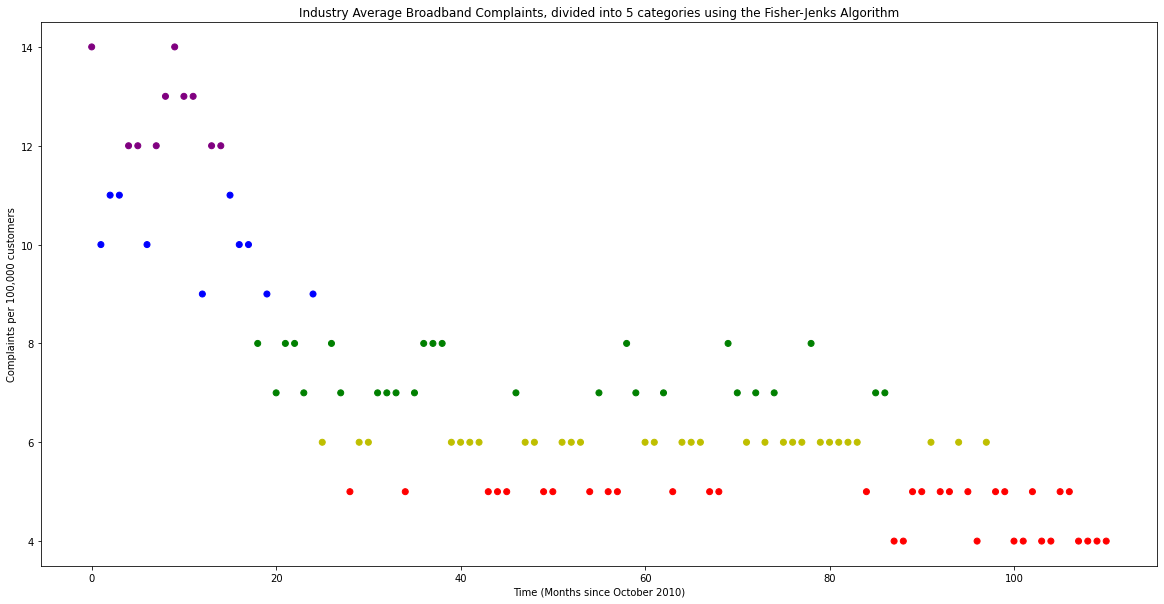

In [191]:
# Completed Functions
def sort_monthly_indices(cd_df):
  # A list input of the indices
  # INDEX FORMAT: 'AA 20BB'
  indices = list(cd_df.index.values)
  columns = list(cd_df.columns)
  col_values = list(cd_df.iloc[:,0])
  col_values2 = list(cd_df.iloc[:,1])
  a, b = [], []
  
  for index in indices: 
      a.append(index[0:1]) #
      b.append(index[5:7])
  indices = np.array([indices, a, b, col_values, col_values2]).T
  indices = indices[indices[:,2].argsort()]
  # Sort the subsets of same years by quarter
  pointer_1, pointer_c = 0, 0
  temp_output = indices # Make a copy, because it would erase the array as it went along
  for index in indices: 
    if (index[2] != indices[pointer_1][2]):
      temp_output[pointer_1:pointer_c, :] = temp_output[pointer_1:pointer_c, :][temp_output[pointer_1:pointer_c, :][:,1].argsort()]
      pointer_1 = pointer_c
    pointer_c +=1

  pointer_c = np.shape(temp_output)[0] - 1
  temp_output[pointer_1:pointer_c, :] = temp_output[pointer_1:pointer_c, :][temp_output[pointer_1:pointer_c, :][:,1].argsort()] 
  indices = pd.DataFrame(data=indices[:,3:], index=indices[:,0], columns=columns)
  return indices

# Fisher-Jenks Algorithm on all the complaints datasets
# Create some Clones for transforms: 
df_cda_ia_t = df_cda_ia.copy()
df_cda_sky_t = df_cda_sky.copy()
df_cda_valid_t = df_cda_valid.copy()

df_cda_ia_t = df_cda_ia_t.T
df_cda_sky_t = df_cda_sky_t.T
df_cda_valid_t = df_cda_valid_t.T

# Industry Average JP 
n = 5 # Number of buckets
df_cda_ia_t_temp = df_cda_ia_t.copy().iloc[:,0]
df_cda_ia_t_temp = df_cda_ia_t_temp.sort_values(ascending=False)
df_cda_ia_t = df_cda_ia_t_temp.to_frame()

# Split into n subgroups divided naturally by variances and means
breaks = jenkspy.jenks_breaks(df_cda_ia_t.iloc[:,0], nb_class=n)
labels = ['bucket_{}'.format(i+1) for i in range(n)]
df_cda_ia_t['cut_jenksv2'] = pd.cut(df_cda_ia_t.iloc[:,0],
                        bins=breaks,
                        labels=labels,
                        include_lowest=True)

df_cda_ia_t = sort_monthly_indices(df_cda_ia_t)

# Display the dataset in a clustered graph
colors = ['r', 'y', 'g', 'b', 'purple', 'black']
colors_lst = []
for bucket in df_cda_ia_t.iloc[:,-1]: 
  current_color_i = int(bucket[-1])
  colors_lst.append(colors[current_color_i - 1])
  
plt.scatter([i for i in range(len(df_cda_ia_t.index))] , [float(element) for element in df_cda_ia_t.iloc[:,0]], color=colors_lst)
plt.xlabel('Time (Months since October 2010)')
plt.ylabel('Complaints per 100,000 customers')
plt.title('Industry Average Broadband Complaints, divided into 5 categories using the Fisher-Jenks Algorithm')
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig("ComplaintsDivideGraph.png")
files.download("ComplaintsDivideGraph.png") 
plt.show()

